In [1]:
from numba import jit
import numpy as np
from numba import jit, int32, float32, types, typed
from numba.typed import List
from numba.experimental import jitclass
import matplotlib.pyplot as plt
import pandas as pd
from modules.Plotter import Plotter

### Constants

In [2]:
c = 3*10**8 # [m^2/s]

In [3]:
@jit(nopython=True, fastmath=True, parallel = True)
def propagate(particle_id, gyro_radius, v, delta_rho_div_phi, mean_free_path, spheres):
    pos = [0.0, 0.0, 0.0]
    phi = 0.0
    particle_info = []
    direction = [1,1,1]
    isotrop = False
    distance = 0.0
    tau_step = gyro_radius / v
    tau = [1.0*mean_free_path[0] / v, 1.0*mean_free_path[1] / v] # [s] time needed to reach plateau
    xi = [1.0 / tau[0], 1.0 / tau[1]] # [1/s] frequency of change
    prob = [xi[0] * tau_step, xi[1] * tau_step]
    
    for i in range(1,10**5): 
        pos_prev = pos
        
        ### change direction #############################################################
        if np.random.random() < prob[0]:
            direction[0] = -1*direction[0]
        if np.random.random() < prob[0]:
            direction[1] = -1*direction[1]
        if np.random.random() < prob[1]:
            direction[2] = -1*direction[2]
            
        ### move in updated direction ####################################################
        if isotrop:
            normalize = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
            time = i # ToDo change this (need to incooperate steplength)
            for j in range(3):
                pos[j] = pos[j] + direction[j]/normalize
        else:
            ### move in z direction as much as in the x or y-direction (in average)
            distance_in_step = v * tau_step
            distance = distance + distance_in_step
            chi_z = direction[2] * distance_in_step / 3**0.5
            delta_r_squared = 2/3 * v**2 * tau_step**2  # delta_r_squared = delta_phi_squared + delta_rho_squared
                 
            ### move in phi direction 
            phi_old = phi
            delta_r_phi = (delta_r_squared / (1 + delta_rho_div_phi**2))**0.5
            delta_phi = np.arccos(1 - delta_r_phi**2 / (2 * gyro_radius**2))
            phi = phi_old + delta_phi * direction[0]
            chi_x = gyro_radius * (np.cos(phi) - np.cos(phi_old)) 
            chi_y = gyro_radius * (np.sin(phi) - np.sin(phi_old))
             
            ### move in rho direction
            delta_rho = delta_rho_div_phi * delta_r_phi
            chi_x = chi_x + np.cos(phi) * direction[1] * delta_rho
            chi_y = chi_y + np.sin(phi) * direction[1] * delta_rho
            
 
            ### move !!!
            pos[0] = pos[0] + chi_x
            pos[1] = pos[1] + chi_y
            pos[2] = pos[2] + chi_z
            

        
        ### observer ####################################################################
        r2_prev = pos_prev[0]**2+pos_prev[1]**2+pos_prev[2]**2
        r2 = pos[0]**2+pos[1]**2+pos[2]**2
        if i<1000 or i%500 == 0:
            particle_info.append([particle_id, i, distance, pos[0], pos[1], pos[2], -1.0])
        for r2_sphere in spheres:
            if r2_prev > r2_sphere and r2 <= r2_sphere or r2_prev < r2_sphere and r2 >= r2_sphere:
                particle_info.append([particle_id, i, distance, pos[0], pos[1], pos[2], r2_sphere*1.0])
        
    return particle_info

In [4]:
@jit(nopython=True, fastmath=True, parallel = True)
def many_particles(gyro_radius, v, delta_rho_div_phi, mean_free_path, observer_spheres):
    data = [[0.0, 0.0, 0.0, 0.0, -1.0]]
    for i in range(10**2):
        particle_id = i
        data_new = propagate(particle_id, gyro_radius, v, delta_rho_div_phi, mean_free_path, observer_spheres)
        data = data + data_new

    print('finished')
    return data

In [5]:
def plot_kappa(df):
    # remove duplicated elements from list of times 
    steps = []
    [steps.append(i) for i in df['i'] if i not in steps]
    kappa_perp = []
    kappa_para = []
    distance = []
    for i in steps:
        df_i = df.loc[df['i'] == i] # all particles per step
        kappa_perp.append(np.mean(np.array((df_i['x'].values**2+df_i['y'].values**2))/(4*np.array(df_i['d'].values))*c))
        kappa_para.append(np.mean(np.array(df_i['z'].values**2)/(2*np.array(df_i['d'].values))*c))
        distance.append(np.mean(df_i['d'].values))
        
    print(np.log10(np.mean(kappa_para[-10:]))-np.log10(np.mean(kappa_perp[-10:])))
        
    plt.plot(np.array(distance) / (2 * np.pi * gyro_radius), np.array(kappa_perp)*10**4, label='$\kappa_\perp$')
    plt.plot(np.array(distance) / (2 * np.pi * gyro_radius), np.array(kappa_para)*10**4, label='$\kappa_\parallel$')
    plt.xlabel('distance [gyration]')
    plt.ylabel('$\kappa$ [cm$^2$/s]')
    plt.legend()
    plt.loglog()
    plt.show()
    
    plt.axvline(x=mean_free_path[1], c='grey', ls='--', label='$\lambda_\parallel$')
    plt.plot(distance, np.array(kappa_perp)*10**4, label='$\kappa_\perp$')
    plt.plot(distance, np.array(kappa_para)*10**4, label='$\kappa_\parallel$')
    plt.xlabel('distance [m]')
    plt.ylabel('$\kappa$ [cm$^2$/s]')
    plt.legend()
    plt.loglog()
    plt.show()

### Parameters

In [6]:
gyro_radius = 3.086*10**17 # [m]; 10 PeV proton in 1 mucro Gauss B field
v = c
delta_rho_div_phi = 1.0 # (delta_rho / delta_phi)
mean_free_path = [1.0*10**21, 1.0*10**21] # [m]
observer_spheres = np.array([-1.0]) # just a time evolution observer

In [7]:
%time data = many_particles(gyro_radius, v, delta_rho_div_phi, mean_free_path, observer_spheres)

<ipython-input-4-6e95aa853b3c>:6: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mean_free_path' of function 'propagate'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-3-888a01715ab2>", line 2:
@jit(nopython=True, fastmath=True, parallel = True)
def propagate(particle_id, gyro_radius, v, delta_rho_div_phi, mean_free_path, spheres):
^

  data_new = propagate(particle_id, gyro_radius, v, delta_rho_div_phi, mean_free_path, observer_spheres)
<ipython-input-4-6e95aa853b3c>:6: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-3-888a017

finished
Wall time: 2.86 s


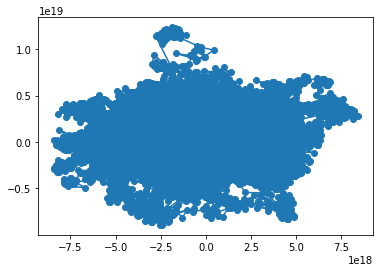

5.963847994534664


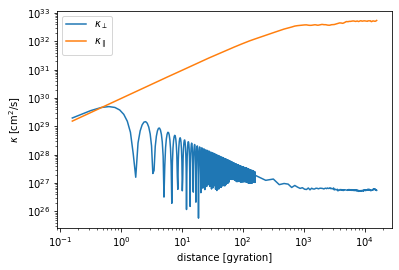

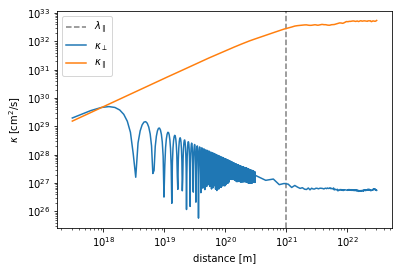

,id,i,d,x,y,z,radius
0,0.0,1.0,3.086000e+17,9.704191e+16,2.690724e+17,1.781703e+17,-1.0
1,0.0,2.0,6.172000e+17,2.917480e+16,5.469413e+17,3.563406e+17,-1.0
2,0.0,3.0,9.258000e+17,-1.809790e+17,7.409838e+17,5.345109e+17,-1.0
3,0.0,4.0,1.234400e+18,-4.633681e+17,7.865190e+17,7.126812e+17,-1.0
4,0.0,5.0,1.543000e+18,-7.238629e+17,6.683686e+17,8.908515e+17,-1.0
...,...,...,...,...,...,...,...
119695,99.0,97500.0,3.008850e+22,-1.157504e+18,-7.059450e+17,6.147588e+21,-1.0
119696,99.0,98000.0,3.024280e+22,-5.135610e+17,-1.383881e+18,6.171463e+21,-1.0
119697,99.0,98500.0,3.039710e+22,2.311988e+17,-1.200406e+18,6.082377e+21,-1.0
119698,99.0,99000.0,3.055140e+22,-3.461821e+17,-8.141333e+17,5.993292e+21,-1.0


In [90]:
df = pd.DataFrame(data[1:])
df.columns = ['id', 'i', 'd', 'x', 'y', 'z', 'radius']
plt.scatter(df['x'], df['y'])
plt.plot(df['x'], df['y'])
plt.show()
plot_kappa(df)
df

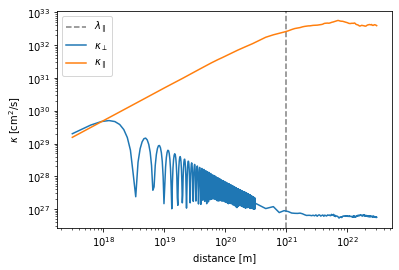

In [85]:

### each step is one second -> times = steps
plt.axvline(x=mean_free_path[1], c='grey', ls='--', label='$\lambda_\parallel$')
plt.plot(distance, np.array(kappa_perp)*10**4, label='$\kappa_\perp$')
plt.plot(distance, np.array(kappa_para)*10**4, label='$\kappa_\parallel$')
plt.xlabel('distance [m]')
plt.ylabel('$\kappa$ [cm$^2$/s]')
plt.legend()
plt.loglog()
plt.show()

In [86]:
print(np.log10(np.mean(kappa_para[-10:]))-np.log10(np.mean(kappa_perp[-10:])))

5.858576029469635


### Lessons learned

The parameter steps_per_gyration moves the first minimum linearly, which is expected -> increasing by 10 moves minima by factor 10 to right